In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [2]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [4]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### MLP with Dropout Regularisation

Use different dropout rates for the input layer (`p_in`) and hidden layers (`p_hidden`). 

In [5]:
seq = [torch.nn.Flatten()]
seq.append(torch.nn.Dropout(p=0.1))
seq.append(torch.nn.Linear(in_features=28*28, out_features=200))
seq.append(torch.nn.ReLU())
seq.append(torch.nn.Dropout(p=0.2))
seq.append(torch.nn.Linear(in_features=200, out_features=10))


In [6]:
model = torch.nn.Sequential(*seq)
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Dropout: 1-2                           [1, 784]                  --
├─Linear: 1-3                            [1, 200]                  157,000
├─ReLU: 1-4                              [1, 200]                  --
├─Dropout: 1-5                           [1, 200]                  --
├─Linear: 1-6                            [1, 10]                   2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.64
Estimated Total Size (MB): 0.64

In [7]:
def create_mlp(units, p_in = 0.0, p_hidden = 0.0, showSummary = False):
    """
    This method can be used for hyperparameter tuning by passing different parameter and receiving
    the mlp with the given hyper parameter.
    :param showSummary: Wheter or not the torchsummary should be displayed
    :param p_in: Drop out rate for the input layer
    :param p_hidden: Drop out rate for the hidden layer
    :return: the mlp
    """

    assert units[0] == 784
    assert units[-1] == 10

    # create list of layers that is later passe to nn.Sequential
    layers = []

    layers.append(torch.nn.Flatten(start_dim = 1, end_dim = -1))
    layers.append(torch.nn.Dropout(p=p_in))

    for idx in range(len(units) - 1):
        layers.append(torch.nn.Linear(in_features=units[idx], out_features=units[idx + 1]))
        if idx != (len(units) - 2):
            layers.append(torch.nn.Dropout(p=p_hidden))
            layers.append(torch.nn.Sigmoid())

    model = torch.nn.Sequential(*layers)

    if showSummary:
        from torchinfo import summary
        summary(model, (1,28,28))

    return model

### Training

Implement the training / evaluation loop

Remember and return training / validation cost and accuracy per epoch.

In [8]:
def test_eval(model, dataset, nbatch = 64):

    test_loader = DataLoader(dataset=dataset, batch_size=nbatch, shuffle=True)

    cost_ce = torch.nn.CrossEntropyLoss()

    test_set_size = len(test_loader.dataset)
    test_num_batches = len(test_loader)

    cost_test, acc_test = 0, 0
    with torch.no_grad():
        for valid_batch_idx, (X, Y) in enumerate(test_loader):
            pred = model(X)
            cost_test += cost_ce(pred, Y).item()
            acc_test += (Y == pred.argmax(dim=1)).type(torch.float).sum().item()
    cost_test = cost_test / test_num_batches
    acc_test = acc_test / test_set_size

    return cost_test, acc_test

In [45]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data):
    

    cost_hist_train = []
    acc_hist_train = []

    cost_hist_valid = []
    acc_hist_valid = []

    # Define cost function and optimizer
    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    training_loader = DataLoader(dataset=training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(dataset=validation_data, batch_size=nbatch, shuffle=True)

    print(f'Start with -> lr: {lr}, bs: {nbatch}, num_epoch: {nepochs}')

    for epoch in range(nepochs):

        # get for both train and test set the length and batch size
        train_set_size = len(training_loader.dataset)
        train_num_batches = len(training_loader)
        validation_set_size = len(validation_loader.dataset)
        validation_num_batches = len(validation_loader)

        cost_train, acc_train = 0, 0

        for train_batch_idx, (X, Y) in enumerate(training_loader):

            # make prediction and calculate loss
            y_pred = model(X)
            loss = cost_ce(y_pred, Y)

            cost_train += loss.item()
            acc_train += (Y == y_pred.argmax(dim=1)).type(torch.float).sum().item()

            # reset gradients, so that they aren't cumulated
            optimizer.zero_grad()

            # calculate gradients
            loss.backward()

            # apply gradients and update parameters
            optimizer.step()

        # calculate average training cost and accuracy per epoch
        cost_train = cost_train / train_num_batches
        acc_train = acc_train / train_set_size

        # evaluate validation cost and accuracy
        cost_valid, acc_valid = test_eval(model, validation_data, nbatch)

        # store result
        cost_hist_train.append(cost_train)
        cost_hist_valid.append(cost_valid)
        acc_hist_train.append(acc_train)
        acc_hist_valid.append(acc_valid)

        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost_train, acc_train, cost_valid, acc_valid))

    
    return cost_hist_train, cost_hist_valid, acc_hist_train, acc_hist_valid

### Analyse Different Settings

Start with a baseline model: 200 units in a single hidden layer; batch size 64; properly tuned learning rate, no dropout.

Then play with different model complexities and dropout rates and compare them on the basis of the validation set.

Estimate also the variance error by the difference between validation and training loss / accuracy.

Finally, identify a favourite combination (model complexity, dropout rate) and compute the test accuracy. 


In [10]:
def find_max(hists):
    print(hists)
    hists = sorted(hists, key=lambda x: x[1][len(x[1]) - 1])
    print(hists)
    return hists[len(hists) - 1] if len(hists) > 0 else []

In [46]:
nbatch = 64
nepochs = 50
lr = 0.25

complexities = [[28*28, 200, 10], [28*28, 300, 10], [28*28, 50, 50, 10], [28*28, 100, 50, 10], [28*28, 200, 100, 50, 10]]
drop_p = [(0.0, 0.0), (0.0, 0.2), (0.2, 0.2), (0.1, 0.3), (0.2, 0.4)]

costs = {"train":[],"valid":[], "test":[]}
accs =  {"train":[],"valid":[], "test":[]}

for config in complexities:
    for p in drop_p:
        print("########")
        print(f"CONFIG -> complexity: {config}, dropout: {p}")
        print("########")

        model = create_mlp(config, p[0], p[1], True)

        cost_hist_train, cost_hist_valid, acc_hist_train, acc_hist_valid = train_eval(model, lr, nepochs, nbatch, training_data, validation_data)
        costs["train"].append(((config, p), cost_hist_train))
        costs["valid"].append(((config, p), cost_hist_valid))
        accs["train"].append(((config, p), acc_hist_train))
        accs["valid"].append(((config, p), acc_hist_valid))

max_hist = find_max(accs["valid"])
test_complexity = max_hist[0][0]
test_drop_p = max_hist[0][1]
test_model = create_mlp(test_complexity, test_drop_p[0], test_drop_p[1], True)
cost_hist_test, acc_hist_test = test_eval(test_model, test_data, nbatch)
costs["test"].append(((test_complexity, p), cost_hist_test))
accs["test"].append(((test_complexity, p), acc_hist_test))


########
CONFIG -> complexity: [784, 50, 10], dropout: (0.0, 0.0)
########
Start with -> lr: 0.25, bs: 64, num_epoch: 2
Epoch 0: 0.773454, 0.739640, 0.542144, 0.807200
Epoch 1: 0.481298, 0.828680, 0.491100, 0.822400
########
CONFIG -> complexity: [784, 50, 10], dropout: (0.0, 0.2)
########
Start with -> lr: 0.25, bs: 64, num_epoch: 2
Epoch 0: 0.813361, 0.727720, 0.655344, 0.759300
Epoch 1: 0.512842, 0.818060, 0.516725, 0.815700
########
CONFIG -> complexity: [784, 40, 10], dropout: (0.0, 0.0)
########
Start with -> lr: 0.25, bs: 64, num_epoch: 2
Epoch 0: 0.778705, 0.738620, 0.577652, 0.791600
Epoch 1: 0.481650, 0.827740, 0.485773, 0.827200
########
CONFIG -> complexity: [784, 40, 10], dropout: (0.0, 0.2)
########
Start with -> lr: 0.25, bs: 64, num_epoch: 2
Epoch 0: 0.830710, 0.723680, 0.577877, 0.801800
Epoch 1: 0.514745, 0.817940, 0.529914, 0.809100
[(([784, 50, 10], (0.0, 0.0)), [0.8072, 0.8224]), (([784, 50, 10], (0.0, 0.2)), [0.7593, 0.8157]), (([784, 40, 10], (0.0, 0.0)), [0.7916

### Suitable Output Plots

Possibly adjust to fit your needs...

(([784, 40, 10], (0.0, 0.2)), 2.3387133695517375)


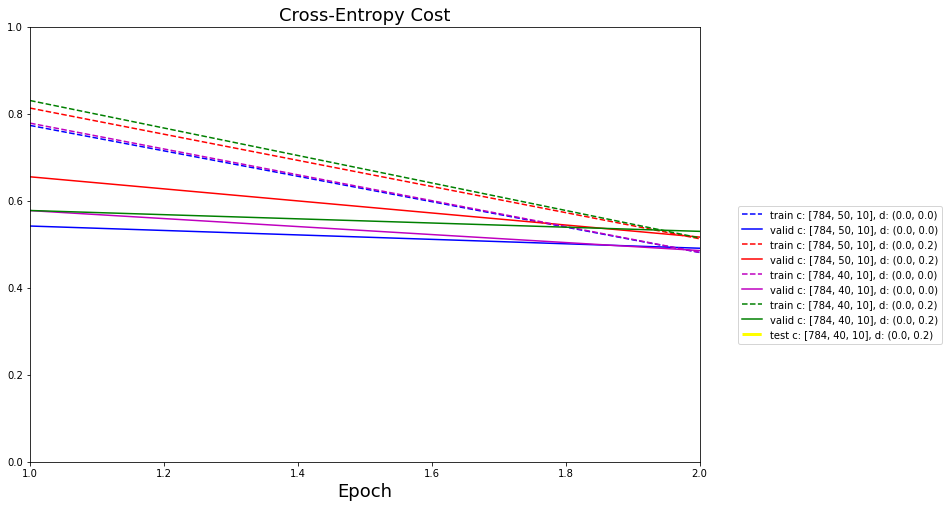

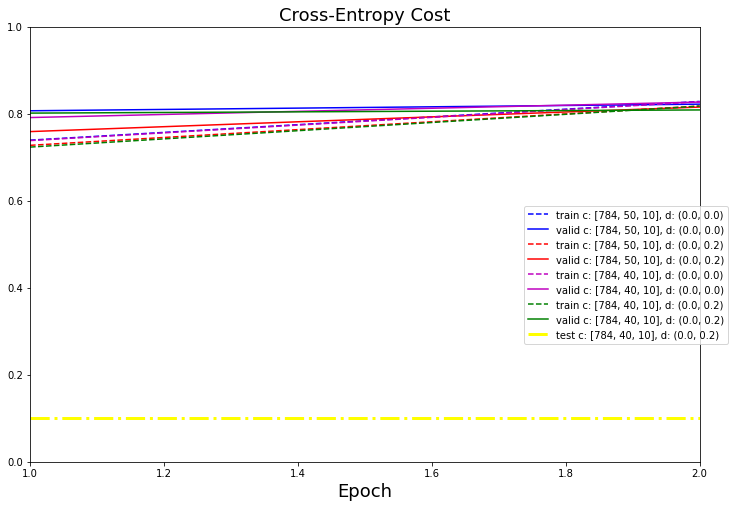

In [77]:
colors = ["b--","r--","m--","g--","y--"]
colors_test = ["b-","r-","m-","g-","y-"]
plt.figure(1, figsize=(12,8))
for i in range(len(costs["train"])):

    _cost_train = costs["train"][i]
    _cost_train_hist = _cost_train[1]
    _cost_train_complexity = _cost_train[0][0]
    _cost_train_dropout = _cost_train[0][1]


    _cost_valid = costs["valid"][i]
    _cost_valid_hist = _cost_valid[1]
    _cost_valid_complexity = _cost_valid[0][0]
    _cost_valid_dropout = _cost_valid[0][1]

    plt.plot(torch.arange(nepochs) + 1, _cost_train_hist, colors[i], label=f"train c: {_cost_train_complexity}, d: {_cost_train_dropout}")
    plt.plot(torch.arange(nepochs) + 1, _cost_valid_hist, colors_test[i], label=f"valid c: {_cost_valid_complexity}, d: {_cost_valid_dropout}")




for i in range(len(costs["test"])):
    cost_test = costs["test"][i]
    cost_test_hist = cost_test[1]

    print(cost_test)
    cost_test_complexity = cost_test[0][0]
    cost_test_dropout = cost_test[0][1]

    plt.axhline(y=cost_test_hist, color='yellow', linestyle='-.', linewidth=3, label=f"test c: {cost_test_complexity}, d: {cost_test_dropout}")


plt.xlabel("Epoch", fontsize=18)
plt.xlim(1,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost", fontsize=18)
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.show()


plt.figure(2, figsize=(12,8))

for i in range(len(accs["train"])):

    _acc_train = accs["train"][i]
    _acc_train_hist = _acc_train[1]
    _acc_train_complexity = _acc_train[0][0]
    _acc_train_dropout = _acc_train[0][1]


    _acc_valid = accs["valid"][i]
    _acc_valid_hist = _acc_valid[1]
    _acc_valid_complexity = _acc_valid[0][0]
    _acc_valid_dropout = _acc_valid[0][1]

    plt.plot(torch.arange(nepochs) + 1, _acc_train_hist, colors[i], label=f"train c: {_acc_train_complexity}, d: {_acc_train_dropout}")
    plt.plot(torch.arange(nepochs) + 1, _acc_valid_hist, colors_test[i], label=f"valid c: {_acc_valid_complexity}, d: {_acc_valid_dropout}")




for i in range(len(accs["test"])):
    acc_test = accs["test"][i]
    acc_test_hist = acc_test[1]
    acc_test_complexity = acc_test[0][0]
    acc_test_dropout = acc_test[0][1]

    plt.axhline(y=acc_test_hist, color='yellow', linestyle='-.', linewidth=3, label=f"test c: {acc_test_complexity}, d: {acc_test_dropout}")


plt.xlabel("Epoch", fontsize=18)
plt.xlim(1,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost", fontsize=18)
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.figure(2, figsize=(12,8))

plt.show()

plt.show()